# Wiki's Whacky Covid Factory

-Wikipedia is one of the most accessed information websites. People look up topics related to the matter they are researching.

-Recently, one of the topics that was on everyone’s mind was the spread of fake news online. During the COVID lockdown, a period where everyone was home alone, speculations rose, and so did online gossip.

-We want to study the evolution of wiki article visits linked to fake news and see what they teach us.

-While information on Wikipedia is never explicitly labelled as “Fake” and extensive efforts were done to make the info as reliable as possible, we can still cluster articles related to a certain Fake news (eg: Hydroxychloroquine -> Covid treatments, horse medicine, FDA…)

-As such, page visits of properly clustered articles are a powerful tool to monitor interest related to a specific fake news, and whether it was used by users as a resource to fact check their data, or a way to go deeper down the rabbit hole doesn’t matter.

-We want to evaluate the usefulness of Wikipedia as a tool for studying misinformation. Let’s particularly focus on the COVID period (cause loads of misinformation, lots of data, the good stuff)

1. Can we use Wikipedia to identify the date of emergence of specific fake news? And what does it tell us about the public’s interest? Can we differentiate the increase in fake news interest from the general increase in traffic to wikipedia during the lockdown period?

2. Language related theories and fears -> World map of people’s hot topics (language based) -> International vs language specific fake news?

3. A timeline of main COVID fake news and their emergence across different countries. What is the link between mobility

### Libraries

In [ ]:
!pip install googletrans==4.0.0-rc1

In [24]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import json
import numpy as np
import requests
import matplotlib.pyplot as plt
import sys
import re
from bs4 import BeautifulSoup



from helpers.wiki_api_helpers import multi_lang_df, scrape_wikipedia_page
from helpers.utils_helpers import spaces_to_underscore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **PART 0:** OMG check out this incredible TREND!!!! You won't believe your eyes


## **PART 1:** Wiki, wiki, wiki, are you actually useful?

There are too many wikipedia articles, and too many ways of using the platform. Some people want to view articles as a way to confirm whether or not a fake news is fake, and some people might already be convinced and just want to feed their beliefs.

But that doesn't matter! Any interest is interesting for us, as they represent the emergence of viewing trends.

But first, we should be able to differentiate viewpage spikes which are fake news related, vs the normal trend...

### A) Lets extract the global trend of wikipedia articles

We want to identify the global trend of wikipedia articles and remove them from our viewcount analysis. From the wikipedia Top 25 report, we can get the list of the 100 most viewed wikipedia articles yearly.

We extract those and plot their total views between 2019 and 2022

In [17]:
file_paths = [
    'Data/top100_articles/topviews-2019.csv',
    'Data/top100_articles/topviews-2020.csv',
]

# Read the CSV files into dataframes
dataframes = [pd.read_csv(file_path) for file_path in file_paths]

# Apply spaces_to_underscore function to the "Page" column of each dataframe
dataframes = [spaces_to_underscore(df, "Page") for df in dataframes]

# Useful dates
dates = [["20190101", "20191231"], ["20200101", "20201231"]]


In [ ]:
topviews_2019 = fetch_viewcount_df(df=dataframes[0], column="Page", language="en", start_date=dates[0][0], end_date=dates[0][1], granularity="daily")
topviews_2020 = fetch_viewcount_df(df=dataframes[1], column="Page", language="en", start_date=dates[1][0], end_date=dates[1][1], granularity="daily")

C:\Users\cpigu\AppData\Local\Temp\ipykernel_8956\3180845633.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  topviews_grouped = topviews.groupby('timestamp').median()


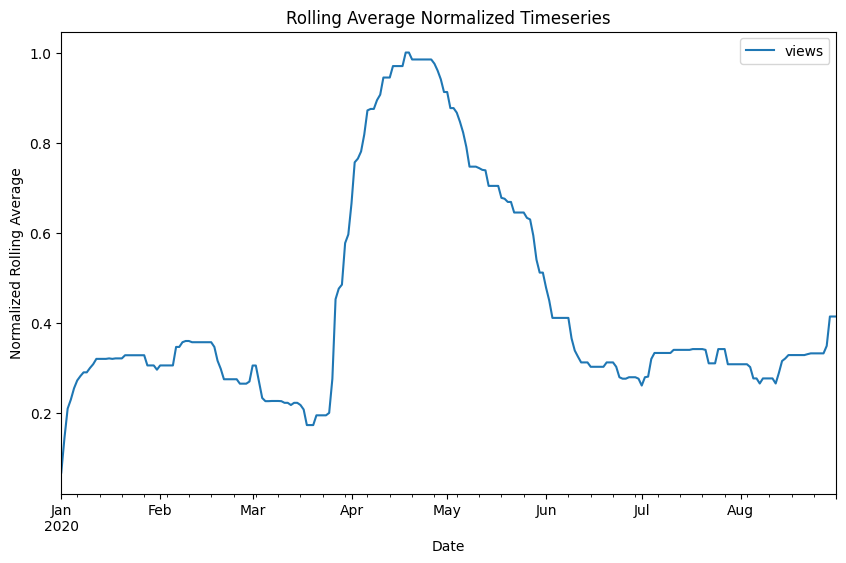

In [ ]:
start_date = "20200101"
end_date = "20200831"

topviews = pd.concat([topviews_2019, topviews_2020])
topviews_grouped = topviews.groupby('timestamp').median()
rolling_average = topviews_grouped.rolling(window=15, min_periods=1).median()
# Min-max normalization
rolling_average_normalized = (rolling_average - rolling_average.min()) / (rolling_average.max() - rolling_average.min())
rolling_average_normalized[start_date:end_date].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Normalized Rolling Average')
plt.title('Rolling Average Normalized Timeseries')
plt.show()


### B) Let's scrape the "COVID-19 misinformation" article

This article is a summary of all the main COVID 19 fake news, and it does a good job at including links of wikipedia articles linked to the topic.

We extract the links of all the articles contained, and group them according to their given subheadings

In [ ]:
headings_en = scrape_wikipedia_page("COVID-19_misinformation", language = "en")

### C) Identifying relevant articles

Not all the parts of the article are interesting and give relevant information. We do a pre selection 

In [ ]:
def getSubLinksFromIntroPablo(links):
    views = []
    for link in links:
        result = fetch_pageview_count("en", link)
        if(len(result) != 0):
            views.append(result)

    return views[0]
 
def existed(article, dateMin="2020-03-01"):
    #check if the first timestamp is less dateMin 
    if pd.Timestamp(article.iloc[0]['timestamp']) <= pd.Timestamp(dateMin):
        return True
    else:
        return False  

def getSubLinksFromIntro(website, nombreMax=10):
    link = "https://en.wikipedia.org/wiki/"+website

    #load online the html file 
    r = requests.get(link)
    soup = BeautifulSoup(r.text, 'html.parser')

    intro = soup.find_all('div', attrs={'class':'mw-content-ltr mw-parser-output'})[0].find_all('p')
    #get the all the href
    links = []
    for i in intro:
        #get the link and not the <a> tag
        try:
            currentLink = i.find_all('a', href=True)[0]['href']
            if(currentLink[0] == '#'):
                continue
            links.append(currentLink)
        except:
            pass

        if(len(links) >= nombreMax):
            break
    
    return links

class wikiTopic:
    df = []

    links = []
    dfView = []
    dfViewFinal = []

    dfSubLinks = []
    dfViewSubLinks = []
    dfViewSubLinksFinal = []

    def __init__(self, df, Maintopic):

        self.dfView = []
        self.dfViewFinal = []
        self.dfViewSubLinks = []
        self.dfViewSubLinksFinal = []
        
        indexes = df["Main Heading"]==Maintopic
        self.df = df[indexes]

        self.extractLinksFromDf()
        self.getViews()

        self.getSublinks()
        #self.getViewsSubLinks()

    def extractLinksFromDf(self):

        linksFinal = []
        for links in self.df.Links:
            links = links[1:-1]
            links = links.split(',')

            links = [re.sub(r'[\[\]\'\s]', '', link) for link in links]
            links = [re.sub(r'/wiki/', '', link) for link in links]
            #concatenate the list
            linksFinal = linksFinal + links
        
        self.links = list(set(linksFinal))

    def getViews(self):
        #fetch view counts
        viewsdf = getSubLinksFromIntroPablo([self.links])
        keys = list(viewsdf.keys())
        #make a list of df 
        for i in range(len(keys)):
            if(existed(viewsdf[keys[i]])):
                self.dfViewFinal.append(viewsdf[keys[i]])
            self.dfView.append(viewsdf[keys[i]])
            
    

    def getSublinks(self):
        for i in range(len(self.links)):
            allSublinks = getSubLinksFromIntro(self.links[i])
            allSublinks = [re.sub(r'/wiki/', '', link) for link in allSublinks]
            #if the sublinks have "#cite_" remove them 
            allSublinks = [link for link in allSublinks if "#cite_" not in link]
            self.dfSubLinks = self.dfSubLinks + allSublinks

        self.dfSubLinks = list(set(self.dfSubLinks))

    def getViewsSubLinks(self):
        #fetch view counts
        viewsdf = getSubLinksFromIntroPablo(self.dfSubLinks)
        keys = list(viewsdf.keys())
        #make a list of df 
        for i in range(len(keys)):
            if(existed(viewsdf[keys[i]])):
                self.dfViewSubLinksFinal.append(viewsdf[keys[i]])
            self.dfViewSubLinks.append(viewsdf[keys[i]])




## **PART 2:** ¿Hablas Fake News?



b) Prove correlation between emergence of news articles and pageviews across multiple languages (cumulative frequency for news articles) 

In [25]:
fetch_data = False
save_data = False
DATA_PATH = "./Data/dif_lang/"
if fetch_data:
    url = "https://en.wikipedia.org/wiki/COVID-19_misinformation"
    languages = ['fr', 'es', 'it'] # List of desired language codes
    headings_df = multi_lang_df(url, languages)
    en = scrape_wikipedia_page(url, language = "en")
    fr = headings_df["fr"]
    es = headings_df["es"]
    it = headings_df["it"]
    if save_data:
        en.to_csv(DATA_PATH + "en.csv", index=False)
        fr.to_csv(DATA_PATH + "fr.csv", index=False)
        es.to_csv(DATA_PATH + "es.csv", index=False)
        it.to_csv(DATA_PATH + "it.csv", index=False)
else:
    en = pd.read_csv('Data/dif_lang/en.csv')
    fr = pd.read_csv('Data/dif_lang/fr.csv')
    es = pd.read_csv('Data/dif_lang/es.csv')
    it = pd.read_csv('Data/dif_lang/it.csv')